In [1]:
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Indicate if output files should be overwritten on this run
write_files = (input("Overwrite files? (y/n)").lower() == "y")

In [2]:
# Set up census and VEST dataframes
va_census_file_path = "../Data/va_vest_20.zip"
va_vest_file_path = "../Data/va_pl2020_vtd.zip"

va_vest = geopandas.read_file(va_census_file_path, engine="pyogrio")
va_census = geopandas.read_file(va_vest_file_path, engine="pyogrio")

va_census["VTD_ID"] = va_census["COUNTYFP20"] + "-" + va_census["VTDST20"]
va_vest["VTD_ID"] = va_vest["COUNTYFP"] + "-" + va_vest["VTDST"]

''' THIS DOESN'T WORK FOR SOME REASON EVEN THOUGH IT SHOULD BE THE SAME AS THE BELOW CODE

va_census["UNIQUE_ID"] = pd.Series(data="CENSUS", index=va_census.index).str.cat(
                            others=[
                                pd.Series(index=va_census.index, data=va_census.index).astype(str), 
                                va_census["COUNTYFP20"],
                                va_census["VTDST20"]
                            ],
                            sep="-")
va_vest["UNIQUE_ID"] = pd.Series(data="VEST", index=va_census.index).str.cat(
                            others=[
                                pd.Series(index=va_vest.index, data=va_vest.index).astype(str),
                                va_vest["COUNTYFP"],
                                va_vest["VTDST"],
                            ],
                            sep="-")
'''
va_census["UNIQUE_ID"] = "CENSUS" + pd.Series(index=va_census.index, data=va_census.index).astype(str) + "-" + va_census["COUNTYFP20"] + "-" + va_census["VTDST20"]
va_vest["UNIQUE_ID"] = "VEST" + pd.Series(index=va_vest.index, data=va_vest.index).astype(str) + "-" + va_vest["COUNTYFP"] + "-" + va_vest["VTDST"]

# Fix incorrect IDs in VEST dataset
shared_vtd_ids = set(va_census["VTD_ID"]) & set(va_vest.value_counts("VTD_ID").where(lambda x : x == 1).dropna().index)
census_bad_ids = set(va_census["VTD_ID"]) - shared_vtd_ids
vest_bad_ids = set(va_vest["VTD_ID"]) - shared_vtd_ids
print("(Before ID fix)")
print(f"{len(shared_vtd_ids)} shared IDs, {len(census_bad_ids)} mismatched IDs in census, {len(vest_bad_ids)} mismatched IDs in VEST")

id_fixes = set([(x[0:4] + x[0:3] + x[-3:]) for x in census_bad_ids if (x[0:4] + x[0:3] + x[-3:]) in vest_bad_ids])
va_vest["VTD_ID"] = va_vest["VTD_ID"].apply(lambda x : x if x not in id_fixes else (x[0:4] + "000" + x[-3:]))

va_census = va_census.sort_values("VTD_ID")
va_vest = va_vest.sort_values("VTD_ID")

(Before ID fix)
2377 shared IDs, 88 mismatched IDs in census, 77 mismatched IDs in VEST


In [3]:
va_vest["UNIQUE_ID"].isnull().sum()

0

In [4]:
# Determine which IDs are shared
shared_vtd_ids = set(va_census["VTD_ID"]) & set(va_vest.value_counts("VTD_ID").where(lambda x : x == 1).dropna().index)
census_bad_ids = set(va_census["VTD_ID"]) - shared_vtd_ids
vest_bad_ids = set(va_vest["VTD_ID"]) - shared_vtd_ids
print(f"{len(shared_vtd_ids)} shared IDs, {len(census_bad_ids)} mismatched IDs in census, {len(vest_bad_ids)} mismatched IDs in VEST")

va_census["is_shared_vtd"] = va_census["VTD_ID"].apply(lambda x : x in shared_vtd_ids)
va_vest["is_shared_vtd"] = va_vest["VTD_ID"].apply(lambda x : x in shared_vtd_ids)

2419 shared IDs, 46 mismatched IDs in census, 35 mismatched IDs in VEST


In [5]:
# Determine the overlap of districts with the same ID
overlap_df = geopandas.GeoDataFrame(index=va_census[va_census["is_shared_vtd"]].set_index("VTD_ID").index)
overlap_df["census_geom"] = va_census[va_census["is_shared_vtd"]].set_index("VTD_ID")["geometry"]
overlap_df["vest_geom"] = va_vest[va_vest["is_shared_vtd"]].set_index("VTD_ID")["geometry"]

overlap_df["overlap"] = overlap_df["census_geom"].intersection(overlap_df["vest_geom"])
overlap_df["census_overlap"] = overlap_df["overlap"].area / overlap_df["census_geom"].area
overlap_df["vest_overlap"] = overlap_df["overlap"].area / overlap_df["vest_geom"].area
 
print(overlap_df["census_overlap"].isnull().sum(), "non-overlapping entries")

0 non-overlapping entries


C:\Users\marcu\AppData\Local\Temp\ipykernel_17084\676265006.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlap_df["census_overlap"] = overlap_df["overlap"].area / overlap_df["census_geom"].area
C:\Users\marcu\AppData\Local\Temp\ipykernel_17084\676265006.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlap_df["vest_overlap"] = overlap_df["overlap"].area / overlap_df["vest_geom"].area


In [6]:
overlap_df["census_overlap"].where(lambda x : x < 0.99).dropna().sort_values()

VTD_ID
059-000723    0.860679
161-000108    0.862517
057-000401    0.884923
135-000201    0.892229
800-000706    0.923861
                ...   
810-000015    0.989546
153-000303    0.989750
710-000203    0.989780
121-000603    0.989941
023-000501    0.989966
Name: census_overlap, Length: 97, dtype: float64

In [7]:
overlap_df["vest_overlap"].where(lambda x : x < 0.99).dropna().sort_values()

VTD_ID
700-000213    0.881213
550-000054    0.882881
059-000915    0.926125
057-000301    0.927200
085-000202    0.929107
                ...   
810-000094    0.989810
510-000112    0.989859
059-000237    0.989861
510-000208    0.989889
059-000628    0.989950
Name: vest_overlap, Length: 89, dtype: float64

In [8]:
overlap_df

,census_geom,vest_geom,overlap,census_overlap,vest_overlap
VTD_ID,,,,,
001-000101,"POLYGON ((-75.42507 37.89957, -75.42499 37.899...","POLYGON Z ((-75.42507 37.89957 0.00000, -75.42...","POLYGON Z ((-75.42499 37.89985 0.00000, -75.42...",1.000000,1.000000
001-000201,"POLYGON ((-75.59978 37.87664, -75.59904 37.877...","POLYGON Z ((-75.59978 37.87664 0.00000, -75.59...","POLYGON Z ((-75.59904 37.87743 0.00000, -75.59...",1.000000,1.000000
001-000202,"POLYGON ((-75.49919 37.93416, -75.49887 37.935...","POLYGON Z ((-75.49919 37.93416 0.00000, -75.49...","POLYGON Z ((-75.49887 37.93525 0.00000, -75.49...",1.000000,1.000000
001-000301,"POLYGON ((-75.64987 37.92702, -75.64979 37.927...","POLYGON Z ((-75.64987 37.92702 0.00000, -75.64...","POLYGON Z ((-75.64979 37.92730 0.00000, -75.64...",1.000000,1.000000
001-000401,"POLYGON ((-75.71556 37.87513, -75.71224 37.875...","POLYGON Z ((-75.71556 37.87513 0.00000, -75.71...","POLYGON Z ((-75.71224 37.87513 0.00000, -75.68...",1.000000,0.999974
...,...,...,...,...,...
840-000102,"POLYGON ((-78.19726 39.19114, -78.19711 39.191...","POLYGON Z ((-78.19726 39.19114 0.00000, -78.19...","POLYGON Z ((-78.19711 39.19143 0.00000, -78.19...",0.997436,1.000000
840-000201,"POLYGON ((-78.16816 39.17746, -78.16787 39.178...","POLYGON Z ((-78.16816 39.17746 0.00000, -78.16...","POLYGON Z ((-78.16787 39.17823 0.00000, -78.16...",1.000000,0.996787
840-000301,"POLYGON ((-78.18626 39.13912, -78.18621 39.139...","POLYGON Z ((-78.18626 39.13912 0.00000, -78.18...","POLYGON Z ((-78.18621 39.13918 0.00000, -78.18...",1.000000,1.000000


In [9]:
census_bad_records = va_census[~va_census["is_shared_vtd"]][["UNIQUE_ID", "geometry"]]
vest_bad_records = va_vest[~va_vest["is_shared_vtd"]][["UNIQUE_ID", "geometry"]]
overlay_check = geopandas.overlay(census_bad_records, vest_bad_records)

c:\Users\marcu\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\geodataframe.py:1815: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union
C:\Users\marcu\AppData\Local\Temp\ipykernel_17084\4286538571.py:3: UserWarning: `keep_geom_type=True` in overlay resulted in 54 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  overlay_check = geopandas.overlay(census_bad_records, vest_bad_records)


In [10]:
overlay_check

,UNIQUE_ID_1,UNIQUE_ID_2,geometry
0,CENSUS2449-003-000407,VEST23-003-000499,"POLYGON Z ((-78.53839 37.98585 0.00000, -78.53..."
1,CENSUS2451-003-000507,VEST27-003-000599,"POLYGON Z ((-78.45495 38.04460 0.00000, -78.45..."
2,CENSUS1833-059-000513,VEST2428-059-000513,"POLYGON Z ((-77.17192 38.83971 0.00000, -77.17..."
3,CENSUS1833-059-000513,VEST2429-059-000513,"MULTIPOLYGON Z (((-77.15854 38.83649 0.00000, ..."
4,CENSUS654-077-004011,VEST1910-077-000401,"POLYGON Z ((-81.08851 36.77032 0.00000, -81.08..."
...,...,...,...
68,CENSUS508-800-000404,VEST2469-800-000404,"POLYGON Z ((-76.57150 36.72469 0.00000, -76.57..."
69,CENSUS493-800-000504,VEST2471-800-000504,"POLYGON Z ((-76.74797 36.73709 0.00000, -76.74..."
70,CENSUS493-800-000504,VEST2473-800-000504,"POLYGON Z ((-76.68891 36.79785 0.00000, -76.68..."
71,CENSUS507-800-000602,VEST2470-800-000602,"POLYGON Z ((-76.58447 36.72694 0.00000, -76.58..."


In [11]:
va_vest["UNIQUE_ID"].isnull().sum()

0

In [12]:
overlay_check["UNIQUE_ID_2"].isnull().sum()

0

In [13]:
va_census_search = va_census.set_index("UNIQUE_ID")
va_vest_search = va_vest.set_index("UNIQUE_ID")

overlay_check["census_overlap"] = overlay_check["geometry"].area / overlay_check["UNIQUE_ID_1"].apply(lambda x : va_census_search.loc[x]["geometry"].area)
overlay_check["vest_overlap"] = overlay_check["geometry"].area / overlay_check["UNIQUE_ID_2"].apply(lambda x : va_vest_search.loc[x]["geometry"].area)

C:\Users\marcu\AppData\Local\Temp\ipykernel_17084\1042105435.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlay_check["census_overlap"] = overlay_check["geometry"].area / overlay_check["UNIQUE_ID_1"].apply(lambda x : va_census_search.loc[x]["geometry"].area)
C:\Users\marcu\AppData\Local\Temp\ipykernel_17084\1042105435.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlay_check["vest_overlap"] = overlay_check["geometry"].area / overlay_check["UNIQUE_ID_2"].apply(lambda x : va_vest_search.loc[x]["geometry"].area)


In [14]:
overlay_check.loc[(overlay_check["census_overlap"] > 0.8) & (overlay_check["vest_overlap"] > 0.8)].count()

UNIQUE_ID_1       24
UNIQUE_ID_2       24
geometry          24
census_overlap    24
vest_overlap      24
dtype: int64

In [15]:
overlay_check

,UNIQUE_ID_1,UNIQUE_ID_2,geometry,census_overlap,vest_overlap
0,CENSUS2449-003-000407,VEST23-003-000499,"POLYGON Z ((-78.53839 37.98585 0.00000, -78.53...",1.000000,0.998046
1,CENSUS2451-003-000507,VEST27-003-000599,"POLYGON Z ((-78.45495 38.04460 0.00000, -78.45...",0.999991,1.000000
2,CENSUS1833-059-000513,VEST2428-059-000513,"POLYGON Z ((-77.17192 38.83971 0.00000, -77.17...",0.542975,1.000000
3,CENSUS1833-059-000513,VEST2429-059-000513,"MULTIPOLYGON Z (((-77.15854 38.83649 0.00000, ...",0.457024,1.000000
4,CENSUS654-077-004011,VEST1910-077-000401,"POLYGON Z ((-81.08851 36.77032 0.00000, -81.08...",1.000000,0.759876
...,...,...,...,...,...
68,CENSUS508-800-000404,VEST2469-800-000404,"POLYGON Z ((-76.57150 36.72469 0.00000, -76.57...",0.139946,1.000000
69,CENSUS493-800-000504,VEST2471-800-000504,"POLYGON Z ((-76.74797 36.73709 0.00000, -76.74...",0.850539,1.000000
70,CENSUS493-800-000504,VEST2473-800-000504,"POLYGON Z ((-76.68891 36.79785 0.00000, -76.68...",0.149457,1.000000
71,CENSUS507-800-000602,VEST2470-800-000602,"POLYGON Z ((-76.58447 36.72694 0.00000, -76.58...",0.989304,1.000000


<Axes: >

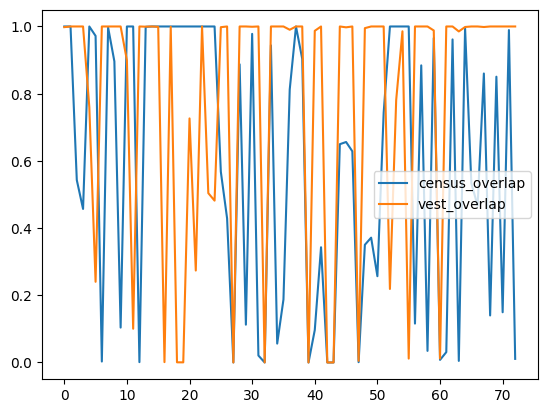

In [16]:
overlay_check[["census_overlap", "vest_overlap"]].plot()

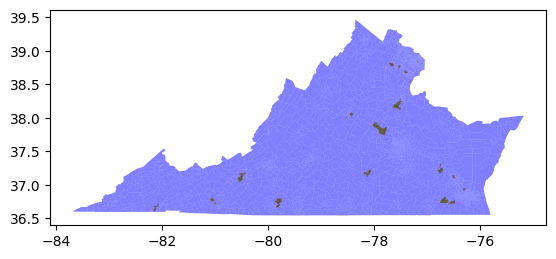

In [17]:
ax = va_census.plot(color="blue", alpha=0.5)
census_bad_records.plot(ax=ax, color="red", alpha=0.5)
vest_bad_records.plot(ax=ax, color="green", alpha=0.5)
plt.show()

In [18]:
bad_overlaps = (((overlay_check["census_overlap"] <= 0.8) | (overlay_check["vest_overlap"] <= 0.8)) & ((overlay_check["census_overlap"] >= 0.1) | (overlay_check["vest_overlap"] >= 0.1)))
bad_overlap_check = overlay_check.loc[bad_overlaps]
bad_overlap_check["census_geom"] = geopandas.GeoSeries(bad_overlap_check["UNIQUE_ID_1"].apply(lambda x : va_census_search.loc[x]["geometry"]))
bad_overlap_check["vest_geom"] = geopandas.GeoSeries(bad_overlap_check["UNIQUE_ID_2"].apply(lambda x : va_vest_search.loc[x]["geometry"]))

c:\Users\marcu\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\marcu\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [19]:
'''
for i in range(len(bad_overlap_check)):
    ax = bad_overlap_check["geometry"].iloc[i:i+1].plot(color="white", edgecolor="black")
    bad_overlap_check["census_geom"].iloc[i:i+1].plot(ax=ax, color="red", alpha=0.5)
    bad_overlap_check["vest_geom"].iloc[i:i+1].plot(ax=ax, color="blue", alpha=0.5)
    plt.show()
'''

'\nfor i in range(len(bad_overlap_check)):\n    ax = bad_overlap_check["geometry"].iloc[i:i+1].plot(color="white", edgecolor="black")\n    bad_overlap_check["census_geom"].iloc[i:i+1].plot(ax=ax, color="red", alpha=0.5)\n    bad_overlap_check["vest_geom"].iloc[i:i+1].plot(ax=ax, color="blue", alpha=0.5)\n    plt.show()\n'

In [69]:
bad_census_vtds = geopandas.GeoDataFrame()
bad_census_vtds["geometry"] = bad_overlap_check.set_index(keys="UNIQUE_ID_1")["census_geom"]
bad_census_vtds["unique_id"] = bad_overlap_check.set_index(keys="UNIQUE_ID_1", drop=False)["UNIQUE_ID_1"]
bad_vest_vtds = geopandas.GeoDataFrame()
bad_vest_vtds["geometry"] = bad_overlap_check.set_index(keys="UNIQUE_ID_2")["vest_geom"]
bad_vest_vtds["unique_id"] = bad_overlap_check.set_index(keys="UNIQUE_ID_2", drop=False)["UNIQUE_ID_2"]
bad_overlap_visualization = pd.concat([bad_census_vtds, bad_vest_vtds])
bad_overlap_visualization["is_census"] = bad_overlap_visualization["unique_id"].str.startswith("CENSUS")

C:\Users\marcu\AppData\Local\Temp\ipykernel_17084\1552775473.py:2: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  bad_census_vtds["geometry"] = bad_overlap_check.set_index(keys="UNIQUE_ID_1")["census_geom"]
C:\Users\marcu\AppData\Local\Temp\ipykernel_17084\1552775473.py:5: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSerie

CENSUS1833-059-000513     True
CENSUS1833-059-000513     True
CENSUS654-077-004011      True
CENSUS653-077-004012      True
CENSUS229-089-000304      True
                         ...  
VEST2472-800-000302      False
VEST2474-800-000302      False
VEST2469-800-000404      False
VEST2473-800-000504      False
VEST2468-800-000602      False
Name: unique_id, Length: 84, dtype: bool

In [65]:
overlap_map = bad_overlap_visualization.explore(column="is_census", cmap=["red", "green"], style_kwds={"opacity": 0.5})
if (write_files):
    overlap_map.save("va_overlap_check.html")

In [ ]:
geopandas.GeoDataFrame.explore

In [36]:
bad_overlap_check["UNIQUE_ID_1"].apply(lambda x : va_census_search.loc[x]["geometry"])

2     CENSUS1833-059-000513
3     CENSUS1833-059-000513
4      CENSUS654-077-004011
5      CENSUS653-077-004012
6      CENSUS229-089-000304
9      CENSUS234-089-000505
11    CENSUS1268-095-001042
12    CENSUS1273-095-000202
16    CENSUS2041-109-007012
18    CENSUS2039-109-007022
19    CENSUS2040-109-007023
20    CENSUS1616-121-002031
21    CENSUS1438-121-002032
23     CENSUS339-135-003011
24     CENSUS337-135-003012
25    CENSUS1381-153-000110
26    CENSUS1381-153-000110
29    CENSUS1383-153-000112
31    CENSUS1396-153-000210
34    CENSUS1427-153-000609
35    CENSUS1504-153-000312
40    CENSUS1029-177-000103
41    CENSUS1042-177-000402
44    CENSUS1026-177-000704
45    CENSUS1042-177-000402
46    CENSUS1023-177-000702
48    CENSUS1026-177-000704
49    CENSUS1023-177-000702
50    CENSUS1024-177-000703
51    CENSUS1024-177-000703
52    CENSUS1137-191-007021
53    CENSUS1140-191-007022
55    CENSUS2049-520-000042
56    CENSUS2356-650-000215
58      CENSUS50-700-000211
61      CENSUS56-700

In [20]:
va_sa_districts = geopandas.read_file("../Data/va_sldl_adopted_2021.zip")

In [21]:
# CHANGE TO VOTING AGE POP
# https://redistrictingdatahub.org/data/about-our-data/pl-94171-dataset/fields-and-descriptions/

census_records = va_census[["UNIQUE_ID", "geometry"]]
census_records["pop_total"] = va_census["P0010001"]
census_records["pop_white"] = va_census["P0010003"]
census_records["pop_black"] = va_census["P0010004"]
census_records["pop_native"] = va_census["P0010005"]
census_records["pop_asian"] = va_census["P0010006"]
census_records["pop_pacific"] = va_census["P0010007"]
census_records["pop_two_or_more"] = va_census["P0010009"]
census_records["pop_hispanic"] = va_census["P0020002"]

census_records["vote_dem"] = ((0.15 + 0.375 * (pd.Series(index=census_records.index, data=census_records.index) % 2)) * census_records["pop_total"]).round(decimals=0)
census_records["vote_rep"] = ((0.525 - 0.375 * (pd.Series(index=census_records.index, data=census_records.index) % 2)) * census_records["pop_total"]).round(decimals=0)
census_records["vote_other"] = (0.05 * census_records["pop_total"]).round(decimals=0)

district_records = va_sa_districts[["DISTRICT", "geometry"]]
district_overlays = geopandas.overlay(census_records, district_records)

c:\Users\marcu\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\marcu\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\marcu\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is tryin

In [22]:
district_overlays["vtd_geom"] = geopandas.GeoSeries(district_overlays["UNIQUE_ID"].apply(lambda x : va_census_search.loc[x]["geometry"]))
district_overlays["vtd_overlap"] = district_overlays["geometry"].area / district_overlays["vtd_geom"].area

C:\Users\marcu\AppData\Local\Temp\ipykernel_17084\749444581.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  district_overlays["vtd_overlap"] = district_overlays["geometry"].area / district_overlays["vtd_geom"].area


In [23]:
district_overlays.where(lambda x : x["vtd_overlap"] > 0.5).dropna().sort_values("vtd_overlap")["UNIQUE_ID"].unique()

array(['CENSUS1773-059-000801', 'CENSUS1908-059-000628',
       'CENSUS2186-155-000401', ..., 'CENSUS2365-051-000501',
       'CENSUS1111-141-000501', 'CENSUS848-075-000401'], dtype=object)

In [24]:
district_overlays["UNIQUE_ID"].value_counts()

CENSUS1424-153-000610    3
CENSUS451-161-000106     2
CENSUS1618-107-000117    2
CENSUS1645-087-000213    2
CENSUS1893-059-000327    2
                        ..
CENSUS2361-051-000401    1
CENSUS2365-051-000501    1
CENSUS2366-051-000502    1
CENSUS805-167-000301     1
CENSUS670-810-000098     1
Name: UNIQUE_ID, Length: 2465, dtype: int64

In [25]:
district_overlays[district_overlays["UNIQUE_ID"] == "CENSUS1424-153-000610"]

,UNIQUE_ID,pop_total,pop_white,pop_black,pop_native,pop_asian,pop_pacific,pop_two_or_more,pop_hispanic,vote_dem,vote_rep,vote_other,DISTRICT,geometry,vtd_geom,vtd_overlap
1902,CENSUS1424-153-000610,6302,1494,2224,43,675,15,814,1805,945.0,3309.0,315.0,19,"POLYGON ((-77.29260 38.62808, -77.29232 38.628...","POLYGON ((-77.33738 38.62289, -77.33723 38.623...",0.166523
1931,CENSUS1424-153-000610,6302,1494,2224,43,675,15,814,1805,945.0,3309.0,315.0,25,"POLYGON ((-77.30231 38.62735, -77.30182 38.627...","POLYGON ((-77.33738 38.62289, -77.33723 38.623...",0.002462
2343,CENSUS1424-153-000610,6302,1494,2224,43,675,15,814,1805,945.0,3309.0,315.0,24,"POLYGON ((-77.33723 38.62311, -77.33707 38.623...","POLYGON ((-77.33738 38.62289, -77.33723 38.623...",0.831015


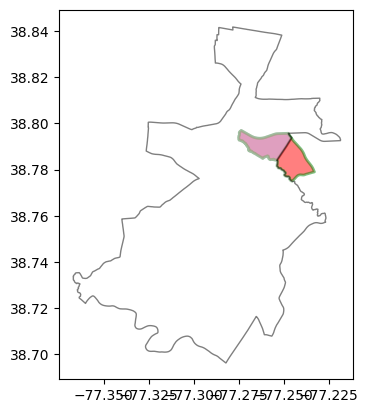

In [26]:
ax = district_overlays["geometry"].iloc[[1681]].plot(color="blue", edgecolor="black", linewidth=2, alpha=0.5)
district_overlays["vtd_geom"].iloc[[1681]].plot(ax=ax, color="red", edgecolor="green", linewidth=2, alpha=0.5)
va_sa_districts["geometry"].loc[[14]].plot(ax=ax, color="white", edgecolor="black", alpha=0.5)
plt.show()

In [27]:
district_data = geopandas.GeoDataFrame(district_overlays.where(lambda x : x["vtd_overlap"] > 0.5)
                                                        .dropna()
                                                        .astype({
                                                            "pop_total": "int",
                                                            "pop_white": "int",
                                                            "pop_black": "int",
                                                            "pop_native": "int",
                                                            "pop_asian": "int",
                                                            "pop_pacific": "int",
                                                            "pop_two_or_more": "int",
                                                            "pop_hispanic": "int",
                                                            "vote_dem": "int",
                                                            "vote_rep": "int",
                                                            "vote_other": "int",
                                                            "DISTRICT": "int"
                                                        })
                                                        .groupby("DISTRICT")
                                                        .sum())
district_data["pct_white"] = district_data["pop_white"] / district_data["pop_total"]
district_data["pct_black"] = district_data["pop_black"] / district_data["pop_total"]
district_data["pct_native"] = district_data["pop_native"] / district_data["pop_total"]
district_data["pct_asian"] = district_data["pop_asian"] / district_data["pop_total"]
district_data["pct_pacific"] = district_data["pop_pacific"] / district_data["pop_total"]
district_data["pct_two_or_more"] = district_data["pop_two_or_more"] / district_data["pop_total"]
district_data["pct_hispanic"] = district_data["pop_hispanic"] / district_data["pop_total"]

district_data["pct_vote_dem"] = district_data["vote_dem"] / district_data["pop_total"]
district_data["pct_vote_rep"] = district_data["vote_rep"] / district_data["pop_total"]
district_data["pct_vote_other"] = district_data["vote_other"] / district_data["pop_total"]

district_data["geometry"] = va_sa_districts.astype({"DISTRICT": "int"}).set_index("DISTRICT")["geometry"]

C:\Users\marcu\AppData\Local\Temp\ipykernel_17084\2335444083.py:31: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  district_data["geometry"] = va_sa_districts.astype({"DISTRICT": "int"}).set_index("DISTRICT")["geometry"]


In [28]:
district_data

,pop_total,pop_white,pop_black,pop_native,pop_asian,pop_pacific,pop_two_or_more,pop_hispanic,vote_dem,vote_rep,...,pct_black,pct_native,pct_asian,pct_pacific,pct_two_or_more,pct_hispanic,pct_vote_dem,pct_vote_rep,pct_vote_other,geometry
DISTRICT,,,,,,,,,,,,,,,,,,,,,
1,85040,60982,3468,481,7620,30,8881,9531,25798,31605,...,0.040781,0.005656,0.089605,0.000353,0.104433,0.112077,0.303363,0.371649,0.050000,"POLYGON ((-77.14679 38.87334, -77.14713 38.873..."
2,84308,52837,6911,332,12035,52,8500,9648,33875,23032,...,0.081973,0.003938,0.142750,0.000617,0.100821,0.114438,0.401801,0.273189,0.049972,"POLYGON ((-77.03893 38.83925, -77.03897 38.839..."
3,85397,43056,11781,837,8436,73,10001,20242,24422,33222,...,0.137956,0.009801,0.098786,0.000855,0.117112,0.237034,0.285982,0.389030,0.049978,"POLYGON ((-77.07409 38.81374, -77.07434 38.813..."
4,88066,27956,21469,1410,10485,46,10664,26585,33418,26026,...,0.243783,0.016011,0.119058,0.000522,0.121091,0.301876,0.379465,0.295528,0.050008,"POLYGON ((-77.14436 38.81036, -77.14397 38.810..."
5,89046,52774,13908,556,5210,51,9594,14344,31871,28233,...,0.156189,0.006244,0.058509,0.000573,0.107742,0.161085,0.357916,0.317061,0.050019,"POLYGON ((-77.04025 38.78522, -77.04136 38.785..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,85233,38678,21322,377,12564,136,9406,8253,24130,33404,...,0.250161,0.004423,0.147408,0.001596,0.110356,0.096829,0.283106,0.391914,0.050016,"POLYGON ((-76.14325 36.75704, -76.14336 36.757..."
97,86862,50224,17877,439,6344,176,9043,8081,24515,34115,...,0.205809,0.005054,0.073035,0.002026,0.104108,0.093033,0.282229,0.392749,0.050010,"POLYGON ((-76.16418 36.78968, -76.16457 36.789..."
98,87497,63316,8592,268,4869,156,8427,6814,32568,26492,...,0.098198,0.003063,0.055648,0.001783,0.096312,0.077877,0.372218,0.302776,0.049990,"POLYGON ((-75.85435 36.55028, -75.86600 36.550..."


In [29]:
output = district_data[["pop_total", "pop_white", "pop_black", "pop_native", "pop_asian", "pop_pacific", "pop_two_or_more", "pop_hispanic", "pct_white", "pct_black", "pct_native", "pct_asian", "pct_pacific", "pct_two_or_more", "pct_hispanic", "vote_dem", "vote_rep", "vote_other", "pct_vote_dem", "pct_vote_rep", "pct_vote_other"]]
if write_files:
    #output.to_file("va-district-stats.json", driver="GeoJSON")
    output.to_json("va-district-stats.json", orient="index")

In [30]:
va_sa_districts.astype({"DISTRICT": "int"}).set_index("DISTRICT")["geometry"]

DISTRICT
1      POLYGON ((-77.14679 38.87334, -77.14713 38.873...
2      POLYGON ((-77.03893 38.83925, -77.03897 38.839...
3      POLYGON ((-77.07409 38.81374, -77.07434 38.813...
4      POLYGON ((-77.14436 38.81036, -77.14397 38.810...
5      POLYGON ((-77.04025 38.78522, -77.04136 38.785...
                             ...                        
96     POLYGON ((-76.14325 36.75704, -76.14336 36.757...
97     POLYGON ((-76.16418 36.78968, -76.16457 36.789...
98     POLYGON ((-75.85435 36.55028, -75.86600 36.550...
99     POLYGON ((-76.01322 36.83731, -76.01322 36.838...
100    POLYGON ((-76.12282 36.85645, -76.12313 36.857...
Name: geometry, Length: 100, dtype: geometry

In [31]:
state_data = district_data[["pop_total", "pop_white", "pop_black", "pop_native", "pop_asian", "pop_pacific", "pop_two_or_more", "pop_hispanic", "vote_dem", "vote_rep", "vote_other"]].sum()
state_data["pop_total"] = state_data["pop_total"].astype(int)
state_data["pct_white"] = state_data["pop_white"] / state_data["pop_total"]
state_data["pct_black"] = state_data["pop_black"] / state_data["pop_total"]
state_data["pct_native"] = state_data["pop_native"] / state_data["pop_total"]
state_data["pct_asian"] = state_data["pop_asian"] / state_data["pop_total"]
state_data["pct_pacific"] = state_data["pop_pacific"] / state_data["pop_total"]
state_data["pct_two_or_more"] = state_data["pop_two_or_more"] / state_data["pop_total"]
state_data["pct_hispanic"] = state_data["pop_hispanic"] / state_data["pop_total"]

state_data["pct_vote_dem"] = state_data["vote_dem"] / state_data["pop_total"]
state_data["pct_vote_rep"] = state_data["vote_rep"] / state_data["pop_total"]
state_data["pct_vote_other"] = state_data["vote_other"] / state_data["pop_total"]

print(state_data.to_json())

{"pop_total":8631393.0,"pop_white":5208856.0,"pop_black":1607581.0,"pop_native":40007.0,"pop_asian":615436.0,"pop_pacific":7156.0,"pop_two_or_more":705707.0,"pop_hispanic":908749.0,"vote_dem":2913517.0,"vote_rep":2912699.0,"vote_other":431577.0,"pct_white":0.6034780249,"pct_black":0.1862481525,"pct_native":0.0046350572,"pct_asian":0.0713020482,"pct_pacific":0.0008290666,"pct_two_or_more":0.0817604991,"pct_hispanic":0.1052841644,"pct_vote_dem":0.3375488754,"pct_vote_rep":0.337454105,"pct_vote_other":0.0500008515}
